In [1]:
# Importing modules
import pandas as pd
import numpy as np
from scripts.preprocessing import preprocess
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.utils import resample
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import joblib
import shap

In [2]:
# Data for training and validation
train_data = preprocess("data/train_set").spectra2df()

# Data for testing (Blind)
test_data = preprocess("data/test_set").spectra2df()

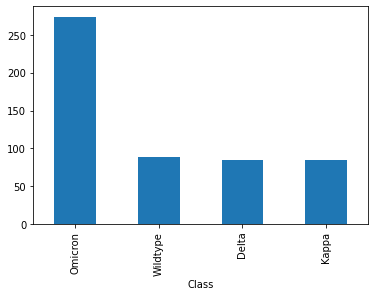

In [3]:
# Class distribution (Training and validation set)
train_data["Class"].value_counts().plot.bar()
plt.show()

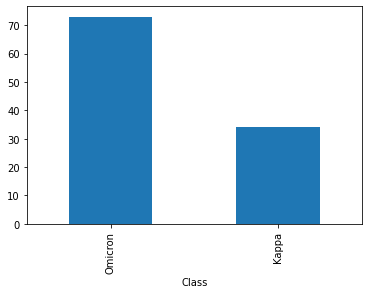

In [4]:
# Class distribution (Test/Blind set)
test_data["Class"].value_counts().plot.bar()
plt.show()

In [5]:
# Target labels
y = train_data["Class"]

# Feature matrix
X = train_data.drop(["Class", "Sample"], axis=1) 

# Training and validation split (80:20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Oversampling training set
oversampler = SMOTE(random_state=42)
X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)

# Scaling training and validation set
sds = StandardScaler()
scaled_X_train = pd.DataFrame(sds.fit_transform(X_train_os), columns=X_train_os.columns)
scaled_X_val = pd.DataFrame(sds.transform(X_val), columns=X_val.columns)
joblib.dump(sds, "models/scaler.pkl") # Saving scaler params

['models/scaler.pkl']

In [6]:
# Model 
classifier = SVC(random_state=42, probability=True)

# Best parameters found after hyperparameter tuning 
params = {"C": [10], "kernel": ["rbf"], "gamma": ["scale"]}

# Model training with 5 fold cv 
grid_search = GridSearchCV(classifier, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(scaled_X_train.to_numpy(), y_train_os)

# Final model
model = grid_search.best_estimator_

In [7]:
# Model Validation
y_pred_val = model.predict(scaled_X_val.to_numpy())

In [8]:
# Classification report (Validation set)
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

       Delta       0.78      0.82      0.80        17
       Kappa       0.78      0.82      0.80        17
     Omicron       0.94      0.91      0.93        55
    Wildtype       0.94      0.94      0.94        18

    accuracy                           0.89       107
   macro avg       0.86      0.88      0.87       107
weighted avg       0.89      0.89      0.89       107



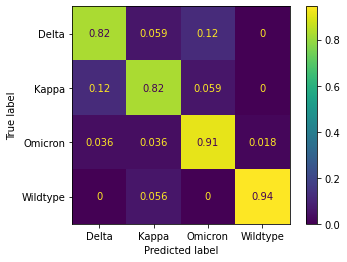

In [9]:
# Confusion matrix (Validation set)
cmat = confusion_matrix(y_val, y_pred_val, normalize="true")
disp_cmat = ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=model.classes_)
disp_cmat.plot()
plt.show()

In [10]:
# Validation accuracy with 95% CI using bootstrapping 
acc_scores = []
for _ in range(1000):
    idx = np.random.choice(len(y_val), size=len(y_val), replace=True)
    acc_scores.append(accuracy_score(y_val.iloc[idx], y_pred_val[idx]))
acc_ci = np.percentile(acc_scores, [2.5, 97.5])
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_val)*100:.2f}%\
\n95% Confidence Interval (CI): {acc_ci[0]*100:.2f}% to {acc_ci[1]*100:.2f}%")

Validation Accuracy: 88.79%
95% Confidence Interval (CI): 83.18% to 94.39%


In [11]:
# Permutation importance for selecting top20 features
result = permutation_importance(model, X_val, y_val, n_repeats=5, random_state=42, n_jobs=-1)
importances = result.importances_mean
top_k_indices = np.argsort(importances)[::-1][:20]  # top 20

# Masking model (zeroing out non top20 features)
def masked_predict(X_subset):
    X_full = np.zeros((X_subset.shape[0], X_train.shape[1]))
    X_full[:, top_k_indices] = X_subset
    return model.predict_proba(X_full)

# Subset train and val set with top20 features
X_train_top = X_train.iloc[:, top_k_indices]
X_val_top = X_val.iloc[:, top_k_indices]
# Subset samples
background = X_train_top.sample(100, random_state=42)
X_val_sample = X_val_top.sample(30, random_state=42)

# SHAP analysis
explainer = shap.KernelExplainer(masked_predict, background)
shap_values = explainer.shap_values(X_val_sample)

  0%|          | 0/30 [00:00<?, ?it/s]

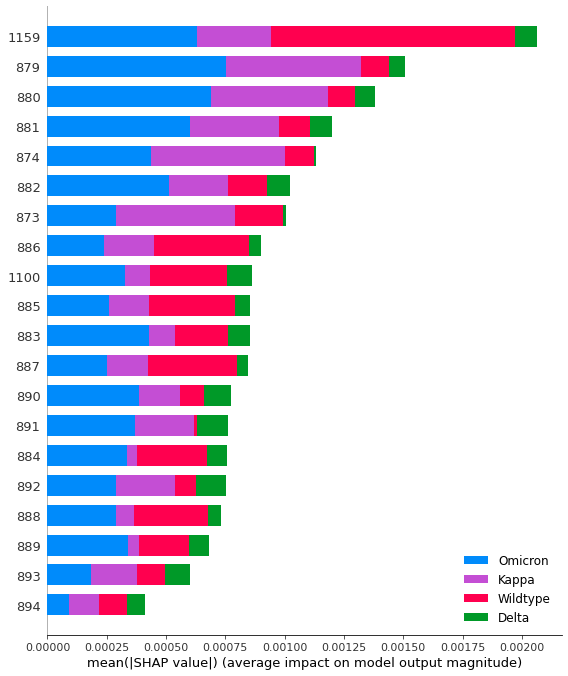

In [12]:
# SHAP summary plot
shap.summary_plot(shap_values, X_val_sample, class_names=model.classes_)

Shap Summary for Delta


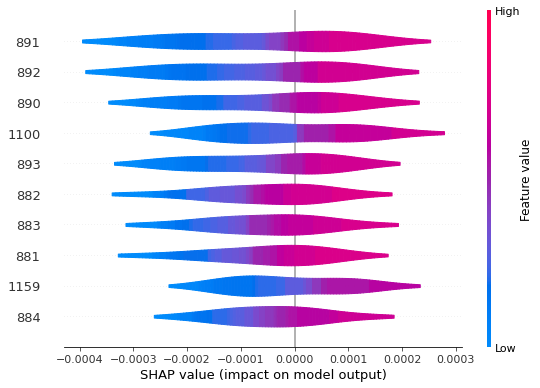

Shap Summary for Kappa


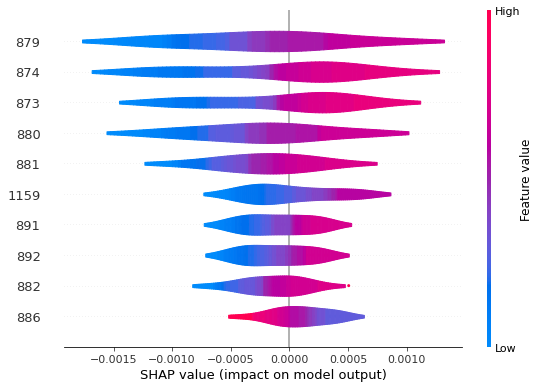

Shap Summary for Omicron


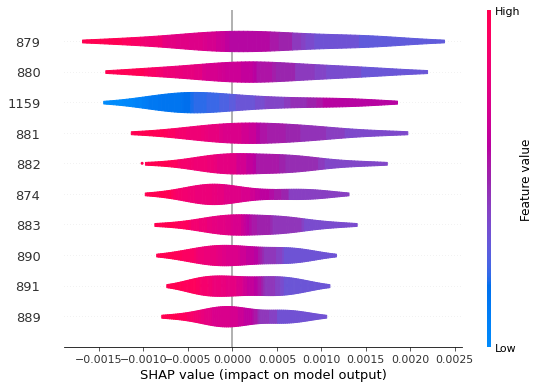

Shap Summary for Wildtype


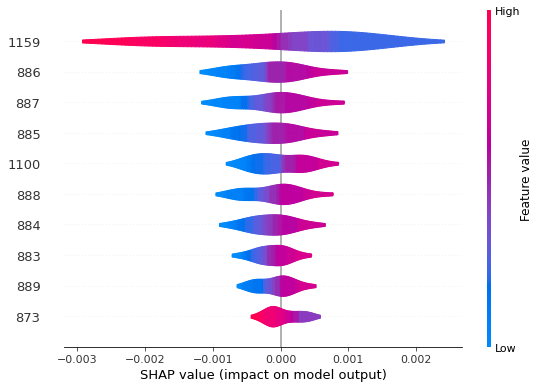

In [13]:
# Summary plot for each class
print(f"Shap Summary for {model.classes_[0]}")
shap.summary_plot(shap_values[0], X_val_sample, max_display=10, plot_type="violin")
print(f"Shap Summary for {model.classes_[1]}")
shap.summary_plot(shap_values[1], X_val_sample, max_display=10, plot_type="violin")
print(f"Shap Summary for {model.classes_[2]}")
shap.summary_plot(shap_values[2], X_val_sample, max_display=10, plot_type="violin")
print(f"Shap Summary for {model.classes_[3]}")
shap.summary_plot(shap_values[3], X_val_sample, max_display=10, plot_type="violin")

In [14]:
# Saving final SVM model
joblib.dump(model, "models/SVM_model.pkl")

['models/SVM_model.pkl']

In [15]:
# Target labels
y_test = test_data["Class"]

# Feature matrix
X_test = test_data.drop(["Class", "Sample"], axis=1)

# Scaling test set
sds = joblib.load("models/scaler.pkl") # Loading scaler params
scaled_X_test = pd.DataFrame(sds.transform(X_test), columns=X_test.columns)

In [16]:
# Loading SVM model
model = joblib.load("models/SVM_model.pkl")

# Model Testing (Evaluation on blind data)
y_pred_test = model.predict(scaled_X_test.to_numpy())

In [17]:
# Classification report (Test set)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       Delta       0.00      0.00      0.00         0
       Kappa       0.61      0.59      0.60        34
     Omicron       0.92      0.82      0.87        73
    Wildtype       0.00      0.00      0.00         0

    accuracy                           0.75       107
   macro avg       0.38      0.35      0.37       107
weighted avg       0.82      0.75      0.78       107



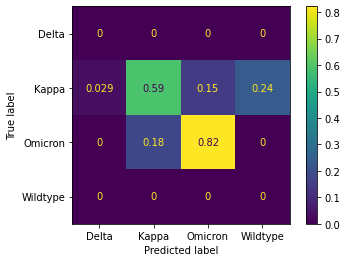

In [18]:
# Confusion matrix (Test set)
cmat = confusion_matrix(y_test, y_pred_test, normalize="true")
disp_cmat = ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=model.classes_)
disp_cmat.plot()
plt.show()

In [19]:
# Test accuracy with 95% CI using bootstrapping 
acc_scores = []
for _ in range(1000):
    idx = np.random.choice(len(y_test), size=len(y_test), replace=True)
    acc_scores.append(accuracy_score(y_test.iloc[idx], y_pred_test[idx]))
acc_ci = np.percentile(acc_scores, [2.5, 97.5])
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test)*100:.2f}%\
\n95% Confidence Interval (CI): {acc_ci[0]*100:.2f}% to {acc_ci[1]*100:.2f}%")

Test Accuracy: 74.77%
95% Confidence Interval (CI): 67.29% to 83.18%
